# Cleaning Nepal’s Tourism Data 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
df = pd.read_csv('tourism_raw.csv', parse_dates=['month'])
regions = pd.read_csv('tourist_region.csv')
df.head()

,month,country,arrivals
0,2023-01-01,India,13685.0
1,2023-01-01,China,7043.0
2,2023-01-01,USA,6349.0
3,2023-01-01,UK,4013.0
4,2023-01-01,Bhutan,2457.0


## Handle Missing Values

In [3]:
df = df.sort_values(['country', 'month'])
df['arrivals'] = df.groupby('country')['arrivals'].transform(lambda s: s.interpolate(limit_direction='both'))
df['arrivals'] = df['arrivals'].fillna(df.groupby('country')['arrivals'].transform('median'))
df.isna().sum()


month       0
country     0
arrivals    1
dtype: int64

## Remove Duplicates

In [4]:
df = df.sort_values(['country', 'month'])
df['arrivals'] = df.groupby('country')['arrivals'].transform(lambda s: s.interpolate(limit_direction='both'))
df['arrivals'] = df['arrivals'].fillna(df.groupby('country')['arrivals'].transform('median'))
Q1 = df['arrivals'].quantile(0.25)
Q3 = df['arrivals'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['arrivals'] >= lower) & (df['arrivals'] <= upper)]
df.isna().sum()

month       0
country     0
arrivals    0
dtype: int64

## Detect & Cap Outliers

In [5]:
def winsorize(group):
 q1, q3 = group['arrivals'].quantile([0.25,0.75])
 iqr = q3-q1; low=q1-1.5*iqr; high=q3+1.5*iqr
 group['arrivals']=group['arrivals'].clip(low, high)
 return group
df = df.groupby('country', group_keys=False).apply(winsorize)
df.describe()

/var/folders/k9/0ymr366x2c5c2hpzhnpzt0100000gn/T/ipykernel_9957/1869895742.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('country', group_keys=False).apply(winsorize)


,month,arrivals
count,171,171.000000
mean,2023-12-14 22:27:22.105263104,5294.850877
min,2023-01-01 00:00:00,1888.000000
25%,2023-07-01 00:00:00,3254.500000
50%,2023-12-01 00:00:00,4431.000000
75%,2024-06-01 00:00:00,6334.000000
max,2024-12-01 00:00:00,15829.000000
std,NaN,2918.113453


## Merge with Region Lookup

In [6]:
regions = regions.rename(columns={'country_clean': 'country'})
df = df.merge(regions, on='country', how='left')
df.head()

,month,country,arrivals,region
0,2023-01-01,Australia,2633.0,Oceania
1,2023-02-01,Australia,3426.0,Oceania
2,2023-03-01,Australia,4219.0,Oceania
3,2023-04-01,Australia,3523.0,Oceania
4,2023-05-01,Australia,4019.0,Oceania


## One-Hot Encoding & Scaling

In [7]:
ohe = OneHotEncoder(sparse_output=False)
ohe_df = pd.DataFrame(
    ohe.fit_transform(df[['region']]),
    columns=ohe.categories_[0],
    index=df.index
)
df = pd.concat([df, ohe_df], axis=1)
sc = StandardScaler()
mm = MinMaxScaler()
df['arrivals_std'] = sc.fit_transform(df[['arrivals']])
df['arrivals_mm'] = mm.fit_transform(df[['arrivals']])
df.head()

,month,country,arrivals,region,East Asia,Europe,North America,Oceania,South Asia,NaN,arrivals_std,arrivals_mm
0,2023-01-01,Australia,2633.0,Oceania,0.0,0.0,0.0,1.0,0.0,0.0,-0.914861,0.053439
1,2023-02-01,Australia,3426.0,Oceania,0.0,0.0,0.0,1.0,0.0,0.0,-0.642312,0.110322
2,2023-03-01,Australia,4219.0,Oceania,0.0,0.0,0.0,1.0,0.0,0.0,-0.369763,0.167205
3,2023-04-01,Australia,3523.0,Oceania,0.0,0.0,0.0,1.0,0.0,0.0,-0.608974,0.117280
4,2023-05-01,Australia,4019.0,Oceania,0.0,0.0,0.0,1.0,0.0,0.0,-0.438502,0.152858


## Visualization

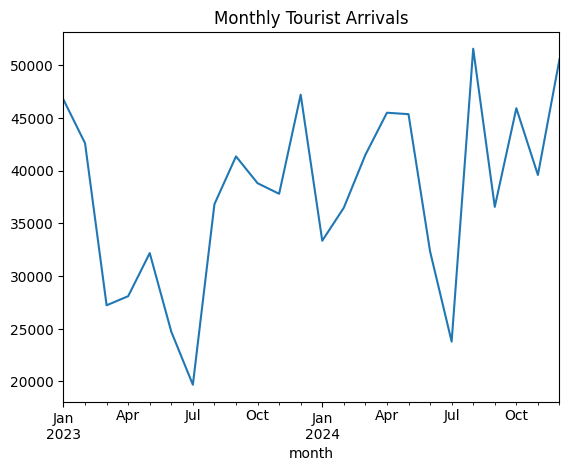

In [8]:
df.groupby('month')['arrivals'].sum().plot(title='Monthly Tourist Arrivals')
plt.show()